In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
import ast
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # for LDA model from gensim
import pickle
import unicodedata
from bertopic import BERTopic
from itertools import chain
nlp = spacy.load("en_core_web_md")
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\argon\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
file_path = 'top_movies_with_synopsis_and_lists.csv'
df = pd.read_csv(file_path)

In [3]:
df[df['Movie']== 'Interstellar']

,Movie,Movie URL,Synopsis,Rating,List Name
5,Interstellar,https://letterboxd.com/film/interstellar/,The adventures of a group of explorers who mak...,4.4,"['Official Top 250 Narrative Feature Films', '..."


In [4]:
# Define normalization function
def normalize_and_lowercase(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', normalized_text)
    return cleaned_text.lower()

In [5]:
# Process 'List Name' as a list of complete list names
def process_list_column(value):
    if isinstance(value, str) and value.startswith('['):
        try:
            # Parse as list of strings and normalize each list name
            parsed_lists = ast.literal_eval(value)
            return [normalize_and_lowercase(list_name) for list_name in parsed_lists]
        except (ValueError, SyntaxError):
            return []
    return []
# Reapply the function to the 'List Name' column
df['List Name'] = df['List Name'].apply(process_list_column)

# Check the transformed "List Name" column to verify the outcome
df

,Movie,Movie URL,Synopsis,Rating,List Name
0,Barbie,https://letterboxd.com/film/barbie/,Barbie and Ken are having the time of their li...,3.8,[movies everyone should watch at least once du...
1,Parasite,https://letterboxd.com/film/parasite-2019/,"All unemployed, Ki-taek’s family takes peculia...",4.6,"[official top 250 narrative feature films, for..."
2,Fight Club,https://letterboxd.com/film/fight-club/,A ticking-time-bomb insomniac and a slippery s...,4.3,"[official top 250 narrative feature films, 100..."
3,Everything Everywhere All at Once,https://letterboxd.com/film/everything-everywh...,An aging Chinese immigrant is swept up in an i...,4.3,"[official top 250 narrative feature films, for..."
4,La La Land,https://letterboxd.com/film/la-la-land/,"Mia, an aspiring actress, serves lattes to mov...",4.1,"[for when you want to feel something, 1001 mov..."
...,...,...,...,...,...
715,A Silent Voice: The Movie,https://letterboxd.com/film/a-silent-voice-the...,Shouya Ishida starts bullying the new girl in ...,4.2,"[for when you want to feel something, movies e..."
716,Hidden Figures,https://letterboxd.com/film/hidden-figures/,"The untold story of Katherine G. Johnson, Doro...",3.9,"[random movie roulette, women have superior ta..."
717,How to Train Your Dragon 2,https://letterboxd.com/film/how-to-train-your-...,Five years have passed since Hiccup and Toothl...,3.8,"[random movie roulette, all the movies sorted ..."
718,The Seventh Seal,https://letterboxd.com/film/the-seventh-seal/,When disillusioned Swedish knight Antonius Blo...,4.3,"[official top 250 narrative feature films, 100..."


In [6]:
unique_values = set(chain.from_iterable(df['List Name']))
len(unique_values)

4504

In [7]:
# Load and preprocess exclusion lists
def load_and_process_exclusion_lists(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        exclusion_lists = file.read().split(", ")
    return [normalize_and_lowercase(list_name) for list_name in exclusion_lists]

In [8]:
# Vectorize lists of texts
def vectorize_texts(text_list):
    return [nlp(text).vector for text in text_list]

In [ ]:
def remove_similar_lists(df, exclusion_file, threshold=0.8):
    """
    This function removes specific list names within the 'List Name' field that are similar
    to any of the exclusion lists based on a cosine similarity threshold.
    """
    try:
        exclusion_lists = load_and_process_exclusion_lists(exclusion_file)
        exclusion_vectors = vectorize_texts(exclusion_lists)
        print(f"Exclusion lists loaded: {exclusion_lists}")
    except FileNotFoundError:
        print(f"Error: Exclusion file '{exclusion_file}' not found.")
        return df  # Return the original DataFrame if the file is missing

    # Process each movie's list names to remove similar lists
    new_list_names = []
    for idx, row in df.iterrows():
        list_names = row['List Name']
        filtered_list_names = []
        for list_name in list_names:
            list_vector = nlp(list_name).vector
            similarities = cosine_similarity([list_vector], exclusion_vectors)[0]
            max_similarity = np.max(similarities)
            if max_similarity < threshold:
                filtered_list_names.append(list_name)  # Keep lists that are dissimilar enough
            else:
                print(f"Row {idx}: Excluding '{list_name}' due to high similarity {max_similarity:.2f}")

        new_list_names.append(filtered_list_names)  # Updated list names for the row
    
    # Update the DataFrame with filtered list names
    df['List Name'] = new_list_names
    print("Finished filtering similar lists from 'List Name'.")
    return df

# Apply the function to remove similar lists within 'List Name'
filtered_df_lists = remove_similar_lists(df, 'ignore_movies.txt', threshold=0.77)

Exclusion lists loaded: ['movies everyone should watch at least once during their lifetime', 'random movie roulette', 'official top 250 films with the most fans', 'letterboxd one million watched club', 'all the movies sorted by movie posters', 'the ultimate i cant pick a movie list', 'every franchise ever', 'film poster deja vu', 'letterboxd top 250 films history collected', 'top 5000 films of all time calculated', 'the 96th academy award feature film nominees', 'most fans on letterboxd with pronoun she2024', 'all time worldwide box office', 'upcomingrecently released movies 20232024 and beyond', 'letterboxd 500 most watched movies of all time', 'indiewires 25 best films of 2023', 'letterboxd easter eggs', 'all major critics lists combined', 'for when you dont know what to watch', 'best picture nominees', '2024 oscars  all nominated films', 'the 96th academy award nominees for best motion picture of the year', 'all movies rated 38 stars or higher with at least 10000 ratings', 'ultimate

In [10]:
filtered_df_lists

,Movie,Movie URL,Synopsis,Rating,List Name
0,Barbie,https://letterboxd.com/film/barbie/,Barbie and Ken are having the time of their li...,3.8,"[ definition of girly classics , films dire..."
1,Parasite,https://letterboxd.com/film/parasite-2019/,"All unemployed, Ki-taek’s family takes peculia...",4.6,[psychosexual dramas nihilistic fever dreams ...
2,Fight Club,https://letterboxd.com/film/fight-club/,A ticking-time-bomb insomniac and a slippery s...,4.3,[psychosexual dramas nihilistic fever dreams ...
3,Everything Everywhere All at Once,https://letterboxd.com/film/everything-everywh...,An aging Chinese immigrant is swept up in an i...,4.3,[psychosexual dramas nihilistic fever dreams ...
4,La La Land,https://letterboxd.com/film/la-la-land/,"Mia, an aspiring actress, serves lattes to mov...",4.1,"[comfort movies, feeling lost in your 20s, bef..."
...,...,...,...,...,...
715,A Silent Voice: The Movie,https://letterboxd.com/film/a-silent-voice-the...,Shouya Ishida starts bullying the new girl in ...,4.2,"[befriending the lyrical loneliness, films dir..."
716,Hidden Figures,https://letterboxd.com/film/hidden-figures/,"The untold story of Katherine G. Johnson, Doro...",3.9,"[written by women, literate movies, black life..."
717,How to Train Your Dragon 2,https://letterboxd.com/film/how-to-train-your-...,Five years have passed since Hiccup and Toothl...,3.8,"[written by women, literate movies, letterboxd..."
718,The Seventh Seal,https://letterboxd.com/film/the-seventh-seal/,When disillusioned Swedish knight Antonius Blo...,4.3,[psychosexual dramas nihilistic fever dreams ...


In [10]:
# Extract unique values from the 'List Name' column
unique_values = set(chain.from_iterable(filtered_df_lists['List Name']))

# Print out the unique values
len(unique_values)

1924

In [11]:
with open('ignore_words.txt', 'r', encoding='utf-8') as file:
    ignore_words = set(file.read().split(', ')) 
    
def process_text(text):
    if isinstance(text, str):  # Check if text is a string
        doc = nlp(text.lower())  # Convert to lowercase and process with SpaCy
        lemmatized_tokens = [
            token.lemma_ 
            for token in doc 
            if not token.is_stop and not token.is_punct and token.lemma_ not in ignore_words  # Remove stop words, punctuation, and ignored words
        ]
        
        # Join tokens back into a string, remove trailing numbers, and strip trailing spaces
        processed_text = ' '.join(lemmatized_tokens)
        processed_text = re.sub(r'\b\d+\b', '', processed_text).strip()
        
        return processed_text
    else:
        return ''  # Return an empty string if text is not valid

# Apply the process_text function to each item in the 'List Name' lists
filtered_df_lists['Processed List Name'] = filtered_df_lists['List Name'].apply(
    lambda lists: [process_text(item) for item in lists] if isinstance(lists, list) else []
)

filtered_df_lists['Processed Synopsis'] = filtered_df_lists['Synopsis'].apply(process_text)


# Combine the processed list names and the processed synopsis for each movie into a new column 'Combined Text'
filtered_df_lists['Combined Text'] = filtered_df_lists.apply(
    lambda row: ' '.join(row['Processed List Name']) + ' ' + row['Processed Synopsis'], axis=1
)
filtered_df_lists

,Movie,Movie URL,Synopsis,Rating,List Name,Processed List Name,Processed Synopsis,Combined Text
0,Barbie,https://letterboxd.com/film/barbie/,Barbie and Ken are having the time of their li...,3.8,"[ definition of girly classics , films dire...","[definition girly classic, direct woman, stuff...",barbie ken have time life colorful seemingly p...,definition girly classic direct woman stuff wo...
1,Parasite,https://letterboxd.com/film/parasite-2019/,"All unemployed, Ki-taek’s family takes peculia...",4.6,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,unemployed ki taek family take peculiar intere...,psychosexual drama nihilistic fever dream su...
2,Fight Club,https://letterboxd.com/film/fight-club/,A ticking-time-bomb insomniac and a slippery s...,4.3,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,tick time bomb insomniac slippery soap salesma...,psychosexual drama nihilistic fever dream su...
3,Everything Everywhere All at Once,https://letterboxd.com/film/everything-everywh...,An aging Chinese immigrant is swept up in an i...,4.3,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,age chinese immigrant sweep insane adventure s...,psychosexual drama nihilistic fever dream su...
4,La La Land,https://letterboxd.com/film/la-la-land/,"Mia, an aspiring actress, serves lattes to mov...",4.1,"[comfort movies, feeling lost in your 20s, bef...","[comfort, feel lose, befriend lyrical loneline...",mia aspire actress serve latte star audition s...,comfort feel lose befriend lyrical loneliness ...
...,...,...,...,...,...,...,...,...
715,A Silent Voice: The Movie,https://letterboxd.com/film/a-silent-voice-the...,Shouya Ishida starts bullying the new girl in ...,4.2,"[befriending the lyrical loneliness, films dir...","[befriend lyrical loneliness, direct woman, as...",shouya ishida start bully new girl class shouk...,befriend lyrical loneliness direct woman asian...
716,Hidden Figures,https://letterboxd.com/film/hidden-figures/,"The untold story of Katherine G. Johnson, Doro...",3.9,"[written by women, literate movies, black life...","[write woman, literate, black life, period arr...",untold story katherine g. johnson dorothy vaug...,write woman literate black life period arrange...
717,How to Train Your Dragon 2,https://letterboxd.com/film/how-to-train-your-...,Five years have passed since Hiccup and Toothl...,3.8,"[written by women, literate movies, letterboxd...","[write woman, literate, , dreamwork, strange b...",year pass hiccup toothless unite dragon viking...,write woman literate dreamwork strange beast ...
718,The Seventh Seal,https://letterboxd.com/film/the-seventh-seal/,When disillusioned Swedish knight Antonius Blo...,4.3,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,disillusioned swedish knight antonius block re...,psychosexual drama nihilistic fever dream su...


In [20]:
'''from gensim.models.phrases import Phrases, Phraser  # Importing Phrases and Phraser

# Step 1: Tokenize the 'Combined Text' column
filtered_df_lists['Tokenized Combined Text'] = filtered_df_lists['Combined Text'].apply(lambda x: x.split())

# Step 2: Build bigram and trigram models based on the tokenized texts
tokenized_texts = filtered_df_lists['Tokenized Combined Text'].tolist()
bigram = Phrases(tokenized_texts, min_count=5, threshold=100)
bigram_phraser = Phraser(bigram)
trigram = Phrases(bigram[tokenized_texts], threshold=100)
trigram_phraser = Phraser(trigram)

# Step 3: Apply bigram and trigram models to the tokenized texts
filtered_df_lists['Tokenized Combined Text'] = filtered_df_lists['Tokenized Combined Text'].apply(
    lambda x: trigram_phraser[bigram_phraser[x]]
)

# Step 4: Convert the processed tokens back into a cleaned text format
filtered_df_lists['Cleaned Combined Text'] = filtered_df_lists['Tokenized Combined Text'].apply(lambda x: ' '.join(x))

# Display the DataFrame with the new 'Cleaned Combined Text' column
filtered_df_lists'''

,Movie,Movie URL,Synopsis,Rating,List Name,Processed List Name,Processed Synopsis,Combined Text,Tokenized Combined Text,Cleaned Combined Text
0,Barbie,https://letterboxd.com/film/barbie/,Barbie and Ken are having the time of their li...,3.8,"[ definition of girly classics , films dire...","[definition girly classic, direct woman, stuff...",barbie ken have time life colorful seemingly p...,definition girly classic direct woman stuff wo...,"[definition_girly, classic, direct, woman, stu...",definition_girly classic direct woman stuff wo...
1,Parasite,https://letterboxd.com/film/parasite-2019/,"All unemployed, Ki-taek’s family takes peculia...",4.6,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,unemployed ki taek family take peculiar intere...,psychosexual drama nihilistic fever dream su...,"[psychosexual_drama_nihilistic_fever, dream, s...",psychosexual_drama_nihilistic_fever dream surr...
2,Fight Club,https://letterboxd.com/film/fight-club/,A ticking-time-bomb insomniac and a slippery s...,4.3,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,tick time bomb insomniac slippery soap salesma...,psychosexual drama nihilistic fever dream su...,"[psychosexual_drama_nihilistic_fever, dream, s...",psychosexual_drama_nihilistic_fever dream surr...
3,Everything Everywhere All at Once,https://letterboxd.com/film/everything-everywh...,An aging Chinese immigrant is swept up in an i...,4.3,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,age chinese immigrant sweep insane adventure s...,psychosexual drama nihilistic fever dream su...,"[psychosexual_drama_nihilistic_fever, dream, s...",psychosexual_drama_nihilistic_fever dream surr...
4,La La Land,https://letterboxd.com/film/la-la-land/,"Mia, an aspiring actress, serves lattes to mov...",4.1,"[comfort movies, feeling lost in your 20s, bef...","[comfort, feel lose, befriend lyrical loneline...",mia aspire actress serve latte star audition s...,comfort feel lose befriend lyrical loneliness ...,"[comfort, feel_lose_befriend_lyrical, loneline...",comfort feel_lose_befriend_lyrical loneliness_...
...,...,...,...,...,...,...,...,...,...,...
715,A Silent Voice: The Movie,https://letterboxd.com/film/a-silent-voice-the...,Shouya Ishida starts bullying the new girl in ...,4.2,"[befriending the lyrical loneliness, films dir...","[befriend lyrical loneliness, direct woman, as...",shouya ishida start bully new girl class shouk...,befriend lyrical loneliness direct woman asian...,"[befriend_lyrical_loneliness, direct, woman, a...",befriend_lyrical_loneliness direct woman asian...
716,Hidden Figures,https://letterboxd.com/film/hidden-figures/,"The untold story of Katherine G. Johnson, Doro...",3.9,"[written by women, literate movies, black life...","[write woman, literate, black life, period arr...",untold story katherine g. johnson dorothy vaug...,write woman literate black life period arrange...,"[write, woman, literate, black, life, period_a...",write woman literate black life period_arrange...
717,How to Train Your Dragon 2,https://letterboxd.com/film/how-to-train-your-...,Five years have passed since Hiccup and Toothl...,3.8,"[written by women, literate movies, letterboxd...","[write woman, literate, , dreamwork, strange b...",year pass hiccup toothless unite dragon viking...,write woman literate dreamwork strange beast ...,"[write, woman, literate, dreamwork, strange_be...",write woman literate dreamwork strange_beast_c...
718,The Seventh Seal,https://letterboxd.com/film/the-seventh-seal/,When disillusioned Swedish knight Antonius Blo...,4.3,[psychosexual dramas nihilistic fever dreams ...,[psychosexual drama nihilistic fever dream s...,disillusioned swedish knight antonius block re...,psychosexual drama nihilistic fever dream su...,"[psychosexual_drama_nihilistic_fever, dream, s...",psychosexual_drama_nihilistic_fever dream surr...


In [12]:
def print_top_words_per_topic(topic_model, n_words=10):
    topics = topic_model.get_topics()
    for topic_num, words in topics.items():
        if topic_num == -1:
            continue  # Skip the -1 topic as it usually denotes outliers
        print(f"Topic {topic_num}:")
        top_words = ', '.join([word for word, _ in words[:n_words]])
        print(f"  Top words: {top_words}\n")

In [29]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

# Adjust UMAP and HDBSCAN parameters
umap_model = UMAP(n_neighbors=12, min_dist=0.1, n_components=5, random_state=21)
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=1, prediction_data=True)

# Initialize BERTopic with custom UMAP and HDBSCAN models
topic_model = BERTopic(
    calculate_probabilities=True,
    nr_topics= 'Auto',  # Set to None to avoid aggressive merging
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
)

# Fit the model
topics, probabilities = topic_model.fit_transform(filtered_df_lists['Combined Text'])

# Print top words for each topic
print_top_words_per_topic(topic_model, n_words=10)


Topic 0:
  Top words: loneliness, people, lyrical, befriend, woman, cinema, comfort, feel, melancholy, love

Topic 1:
  Top words: horror, halloween, creepy, highestrate, scream, release, update, scary, disturbing, gallery

Topic 2:
  Top words: woman, romcom, direct, girl, girly, definition, classic, female, summer, amor

Topic 3:
  Top words: pixar, animation, dreamwork, disney, ranking, computer, comfort, nostalgia, like, plus

Topic 4:
  Top words: romcom, woman, comfort, female, direct, romantic, guide, amor, comedy, romantica

Topic 5:
  Top words: historia, general, period, order, essential, chronological, good, rtruefilm, orden, cronologica

Topic 6:
  Top words: woman, cinema, dream, horror, drama, direct, lesbian, humour, touch, nihilistic

Topic 7:
  Top words: horror, halloween, scary, mike, gallery, disturbing, canon, creepy, update, like

Topic 8:
  Top words: horror, weirdo, a24, disturbing, dream, surrealism, scary, paradise, videostore, cinema

Topic 9:
  Top words: lg

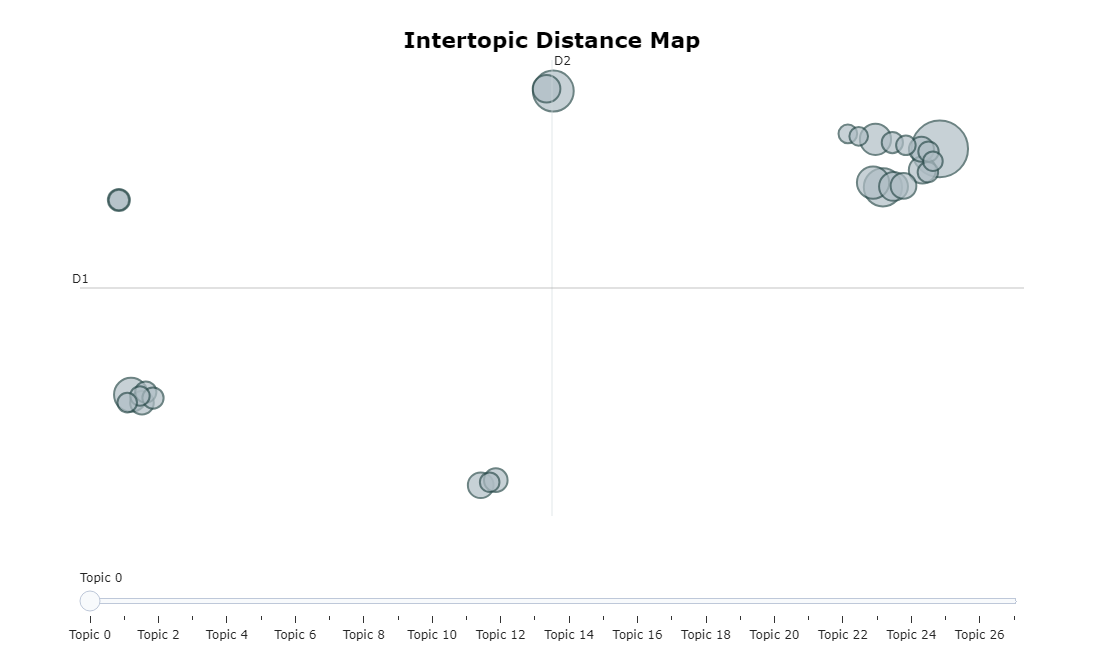

In [30]:
topic_model.visualize_topics()

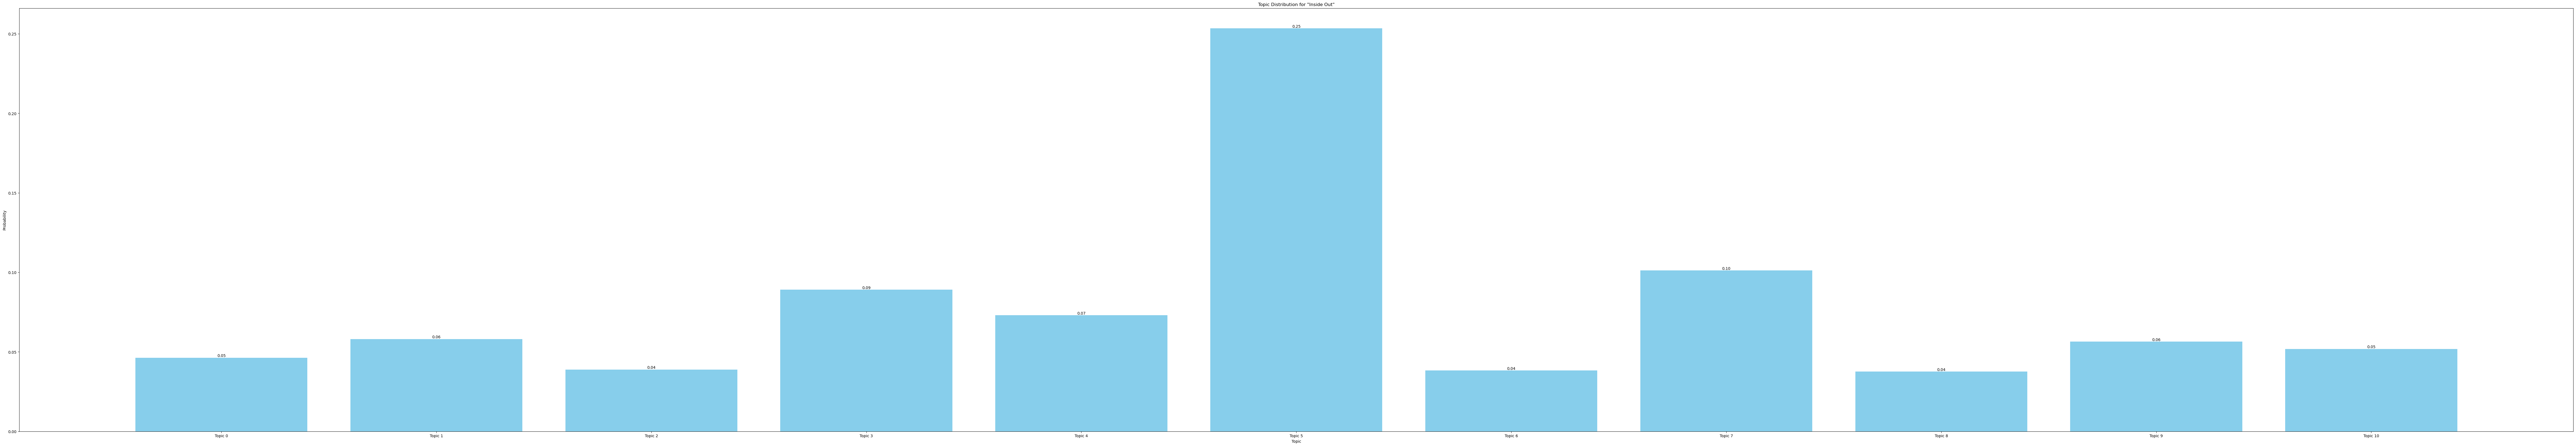

In [26]:
def plot_movie_topics(movie_title):
    movie = filtered_df_lists[filtered_df_lists['Movie'].str.contains(movie_title, case=False, na=False)]
    if movie.empty:
        print(f"Movie '{movie_title}' not found.")
        return
    
    # Get the index of the movie
    movie_idx = movie.index[0]
    
    # Access the full topic probabilities for this movie
    movie_probs = topic_model.probabilities_[movie_idx]
    
    if movie_probs is None:
        print(f"No topic probabilities found for '{movie_title}'. Ensure calculate_probabilities=True when initializing BERTopic.")
        return
    
    # Generate range of topics for the plot
    topics = range(len(movie_probs))
    plt.figure(figsize=(120, 20))
    bars = plt.bar(topics, movie_probs, color='skyblue')
    plt.xlabel('Topic')
    plt.ylabel('Probability')
    plt.title(f'Topic Distribution for \"{movie_title}\"')
    plt.xticks(topics, [f'Topic {i}' for i in topics])
    
    for bar, prob in zip(bars, movie_probs):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{prob:.2f}', ha='center', va='bottom')
    
    plt.show()

# Example usage
target_movie = "Inside Out"  # Replace with the desired movie title
plot_movie_topics(target_movie)
